# Introduction

Hello world!

In this Jupyter notebook, we will embark on an exploration of the intriguing field of **electrocardiogram (ECG)** signal processing and classification, utilizing the capabilities of a **Convolutional Neural Network (CNN) Autoencoder**. Our chosen dataset for this journey is the PTB Diagnostic ECG Database, a meticulously curated collection of ECG signals crafted explicitly for diagnostic purposes. Our primary objective is to construct a robust Autoencoder model tailored for the task of detecting anomalous electrocardiogram (ECG) signals.

## Dataset Overview

The **PTB Diagnostic ECG Database** is a collection of 14,552 ECG recordings sourced from Physionet's PTB Diagnostic Database. These ECG signals are categorized into two classes: normal heartbeats and those affected by cardiac abnormalities. The dataset is sampled at 125Hz, providing high-resolution data for in-depth analysis.

> Let's delve into some essential details about the PTB Diagnostic ECG Database:
> 
> - **Number of Samples:** 14,552
> - **Number of Categories:** 2
> - **Sampling Frequency:** 125Hz
> - **Data Source:** Physionet's PTB Diagnostic Database

<span style="color:red; font-size: 20px;">We kindly request that if you find this notebook useful, please consider upvoting it as a token of appreciation.</span>

## Using Transposed Convolution has improved the model significantly
|                      | Accuracy  | Precision | Recall   | F1 Score  |
|----------------------|-----------|-----------|----------|-----------|
| With upsampling      | 71.99%    | 49.78%    | 87.91%   | 63.57%    |
| With transposed conv | 76.93%    | 55.23%    | 89.81%   | 68.40%    |

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [4]:
normal_df = pd.read_csv("/kaggle/input/heartbeat/ptbdb_normal.csv").iloc[:, :-1]
anomaly_df = pd.read_csv("/kaggle/input/heartbeat/ptbdb_abnormal.csv").iloc[:, :-1]
normal_df.head()

,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.55,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA

In [5]:
print("Shape of Normal data", normal_df.shape)
print("Shape of Abnormal data", anomaly_df.shape)

Shape of Normal data (4045, 187)
Shape of Abnormal data (10505, 187)


The code below generates a visual comparison between two randomly selected ECG signal samples: one from the "Normal" dataset and the other from the "Anomaly" dataset. This side-by-side plot enables a direct visual assessment of ECG signal patterns between normal and anomalous cases.

In [6]:
def plot_sample(normal, anomaly):
    index = np.random.randint(0, len(normal_df), 2)
    
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    ax[0].plot(normal.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[0].plot(normal.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[0].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[0].set_title("Normal")
    
    ax[1].plot(anomaly.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[1].plot(anomaly.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[1].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[1].set_title("Anomaly")
    
    plt.tight_layout()
    plt.show()

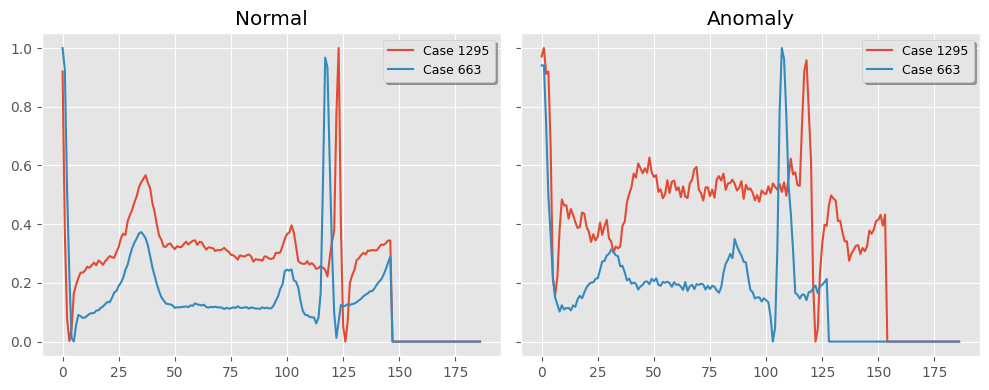

In [7]:
plot_sample(normal_df, anomaly_df)

In [8]:
CLASS_NAMES = ["Normal", "Anomaly"]

normal_df_copy = normal_df.copy()
anomaly_df_copy = anomaly_df.copy()
print(anomaly_df_copy.columns.equals(normal_df_copy.columns))

False


In [9]:
normal_df_copy = normal_df_copy.set_axis(range(1, 188), axis=1)
anomaly_df_copy = anomaly_df_copy.set_axis(range(1, 188), axis=1)
normal_df_copy = normal_df_copy.assign(target = CLASS_NAMES[0])
anomaly_df_copy = anomaly_df_copy.assign(target = CLASS_NAMES[1])


df = pd.concat((normal_df_copy, anomaly_df_copy))

## Smoothed Mean Plot for Class Comparison

In this Python code, a function called `plot_smoothed_mean` is defined for creating smoothed mean plots. It takes input data, a class name, and a step size as parameters. The function calculates the rolling mean and standard deviation of the data with the specified step size, then plots the smoothed mean along with a shaded area representing the margin of three times the standard deviation.

The code also demonstrates the use of this function to compare the smoothed means of different classes. It creates a subplot with two panels, each representing a different class. The data for each class is grouped, and the mean is computed before passing it to the `plot_smoothed_mean` function. This allows for visualizing how the smoothed means of different classes compare.

The resulting plot provides insights into how the means of different classes vary over time or some other variable represented by the data, with shaded areas indicating the uncertainty around the mean estimates.


In [10]:
def plot_smoothed_mean(data, class_name = "normal", step_size=5, ax=None):
    df = pd.DataFrame(data)
    roll_df = df.rolling(step_size)
    smoothed_mean = roll_df.mean().dropna().reset_index(drop=True)
    smoothed_std = roll_df.std().dropna().reset_index(drop=True)
    margin = 3*smoothed_std
    lower_bound = (smoothed_mean - margin).values.flatten()
    upper_bound = (smoothed_mean + margin).values.flatten()

    ax.plot(smoothed_mean.index, smoothed_mean)
    ax.fill_between(smoothed_mean.index, lower_bound, y2=upper_bound, alpha=0.3, color="red")
    ax.set_title(class_name, fontsize=9)

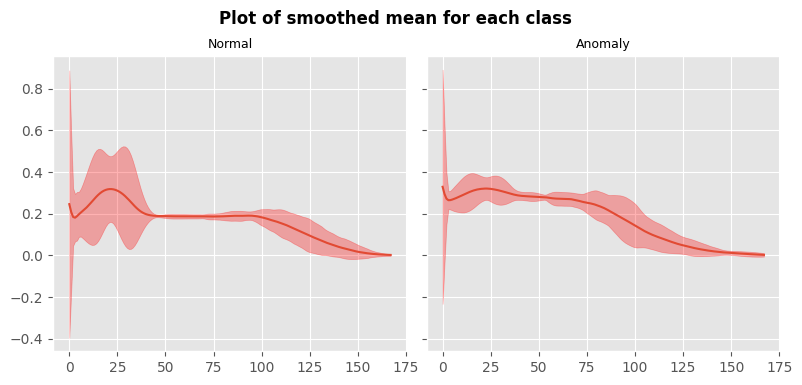

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten()
for i, label in enumerate(CLASS_NAMES, start=1):
    data_group = df.groupby("target")
    data = data_group.get_group(label).mean(axis=0, numeric_only=True).to_numpy()
    plot_smoothed_mean(data, class_name=label, step_size=20, ax=axes[i-1])
fig.suptitle("Plot of smoothed mean for each class", y=0.95, weight="bold")
plt.tight_layout()

## Splitting the data to training and testing set

In [12]:
normal_df.drop("target", axis=1, errors="ignore", inplace=True)
normal = normal_df.to_numpy()
anomaly_df.drop("target", axis=1, errors="ignore", inplace=True)
anomaly = anomaly_df.to_numpy()

X_train, X_test = train_test_split(normal, test_size=0.15, random_state=45, shuffle=True)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, anomaly shape: {anomaly.shape}")

Train shape: (3438, 187), Test shape: (607, 187), anomaly shape: (10505, 187)


# Building CNN Autoencoder Model

## About Autoencoders: Learning Efficient Data Representations

Autoencoders are a class of neural network architectures commonly used in unsupervised machine learning and deep learning tasks. Their primary purpose is to discover and learn efficient representations of data by encoding it into a lower-dimensional latent space and subsequently decoding it back to its original form. Autoencoders play a crucial role in various applications, such as dimensionality reduction, data denoising, anomaly detection, and generative modeling.

The core components of an autoencoder consist of an encoder and a decoder. The encoder maps input data to the latent space, while the decoder reconstructs the data from its encoded representation. During training, autoencoders aim to minimize the reconstruction error between the input and the decoded output, which results in the learning of meaningful data representations.

Autoencoders offer a versatile tool for feature extraction, data compression, and more, making them a valuable addition to the toolkit of data scientists and machine learning practitioners.


![Autoencoder](https://miro.medium.com/v2/resize:fit:640/format:webp/1*nqzWupxC60iAH2dYrFT78Q.png)

In [13]:
tf.keras.utils.set_random_seed(1024)

In [14]:
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])
        # Previously, I was using UpSampling. I am trying Transposed Convolution this time around.
        self.decoder = tf.keras.Sequential([
            layers.Conv1DTranspose(latent_dim, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded


input_dim = X_train.shape[-1]
latent_dim = 32

model = AutoEncoder(input_dim, latent_dim)
model.build((None, input_dim))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mae")
model.summary()

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 24, 32)            63264     
                                                                 
 sequential_1 (Sequential)   (None, 187)               640603    
                                                                 
Total params: 703,867
Trainable params: 702,715
Non-trainable params: 1,152
_________________________________________________________________


In [15]:
epochs = 100
batch_size = 128
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)


history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
25/25 [==============================] - 9s 53ms/step - loss: 2.0049 - val_loss: 1.2965
Epoch 2/100
25/25 [==============================] - 0s 13ms/step - loss: 0.7697 - val_loss: 1.3624
Epoch 3/100
25/25 [==============================] - 0s 12ms/step - loss: 0.5694 - val_loss: 1.3414
Epoch 4/100
25/25 [==============================] - 0s 12ms/step - loss: 0.4710 - val_loss: 1.0884
Epoch 5/100
25/25 [==============================] - 0s 13ms/step - loss: 0.4243 - val_loss: 1.0099
Epoch 6/100
25/25 [==============================] - 0s 12ms/step - loss: 0.3689 - val_loss: 0.8018
Epoch 7/100
25/25 [==============================] - 0s 12ms/step - loss: 0.2620 - val_loss: 0.8874
Epoch 8/100
25/25 [==============================] - 0s 12ms/step - loss: 0.2354 - val_loss: 0.8208
Epoch 9/100
25/25 [==============================] - 0s 12ms/step - loss: 0.1763 - val_loss: 0.3438
Epoch 10/100
25/25 [==============================] - 0s 13ms/step - loss: 0.1622 - val_loss: 0.2609

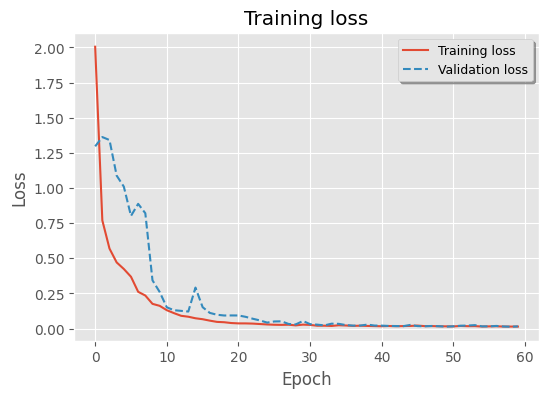

In [16]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [17]:
train_mae = model.evaluate(X_train, X_train, verbose=0)
test_mae = model.evaluate(X_test, X_test, verbose=0)
anomaly_mae = model.evaluate(anomaly_df, anomaly_df, verbose=0)

print("Training dataset error: ", train_mae)
print("Testing dataset error: ", test_mae)
print("Anormaly dataset error: ", anomaly_mae)

Training dataset error:  0.013318626210093498
Testing dataset error:  0.014092662371695042
Anormaly dataset error:  0.03354528546333313


In [18]:
def predict(model, X):
    pred = model.predict(X, verbose=False)
    loss = mae(pred, X)
    return pred, loss

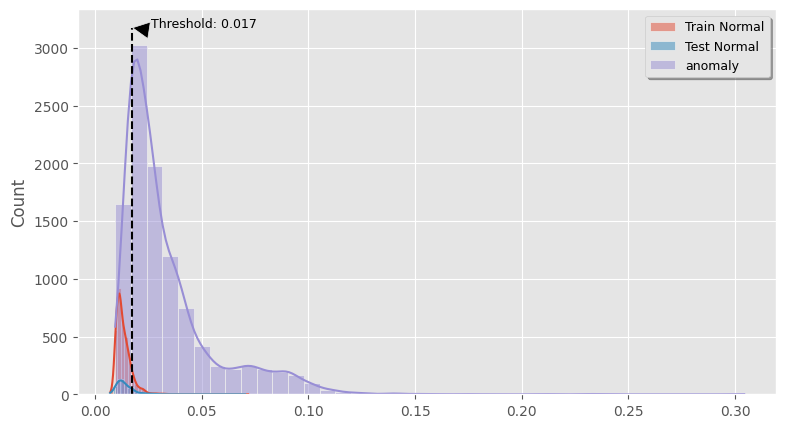

In [19]:
_, train_loss = predict(model, X_train)
_, test_loss = predict(model, X_test)
_, anomaly_loss = predict(model, anomaly)
threshold = np.mean(train_loss) + np.std(train_loss) # Setting threshold for distinguish normal data from anomalous data

bins = 40
plt.figure(figsize=(9, 5), dpi=100)
sns.histplot(np.clip(train_loss, 0, 0.5), bins=bins, kde=True, label="Train Normal")
sns.histplot(np.clip(test_loss, 0, 0.5), bins=bins, kde=True, label="Test Normal")
sns.histplot(np.clip(anomaly_loss, 0, 0.5), bins=bins, kde=True, label="anomaly")

ax = plt.gca()  # Get the current Axes
ylim = ax.get_ylim()
plt.vlines(threshold, 0, ylim[-1], color="k", ls="--")
plt.annotate(f"Threshold: {threshold:.3f}", xy=(threshold, ylim[-1]), xytext=(threshold+0.009, ylim[-1]),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=9)
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.show()

In [20]:
def plot_examples(model, data, ax, title):
    pred, loss = predict(model, data)
    ax.plot(data.flatten(), label="Actual")
    ax.plot(pred[0], label = "Predicted")
    ax.fill_between(range(1, 188), data.flatten(), pred[0], alpha=0.3, color="r")
    ax.legend(shadow=True, frameon=True,
              facecolor="inherit", loc=1, fontsize=7)
#                bbox_to_anchor = (0, 0, 0.8, 0.25))

    ax.set_title(f"{title} (loss: {loss[0]:.3f})", fontsize=9.5)

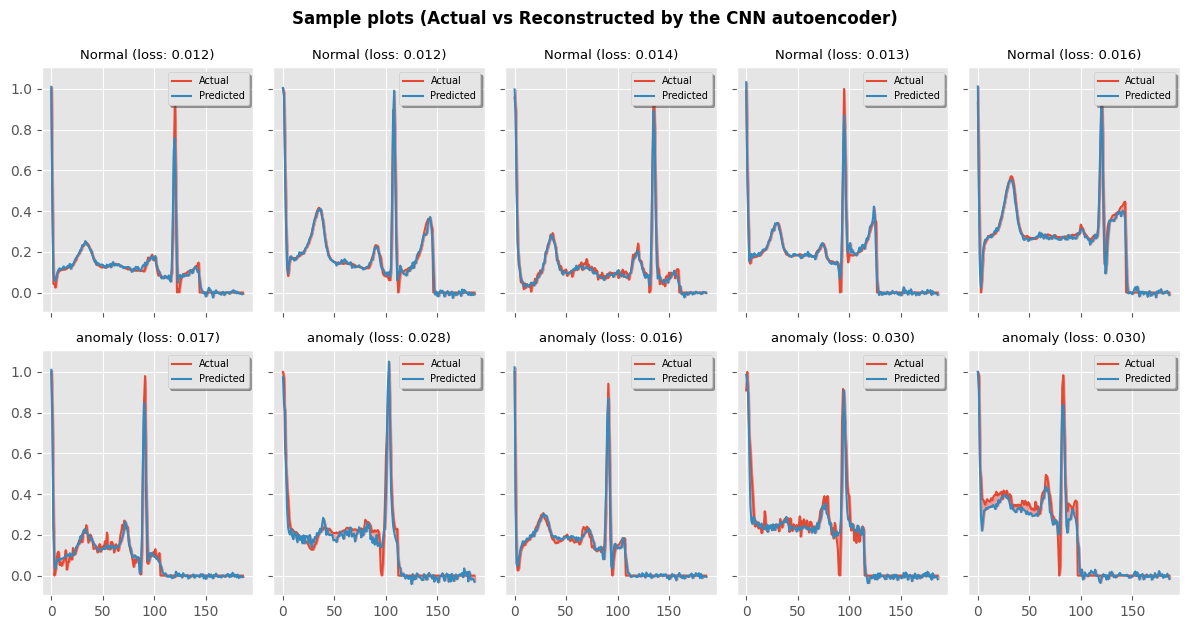

In [21]:
fig, axes = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(12, 6), facecolor="w")
random_indexes = np.random.randint(0, len(X_train), size=5)

for i, idx in enumerate(random_indexes):
    data = X_train[[idx]]
    plot_examples(model, data, ax=axes[0, i], title="Normal")

for i, idx in enumerate(random_indexes):
    data = anomaly[[idx]]
    plot_examples(model, data, ax=axes[1, i], title="anomaly")

plt.tight_layout()
fig.suptitle("Sample plots (Actual vs Reconstructed by the CNN autoencoder)", y=1.04, weight="bold")
fig.savefig("autoencoder.png", dpi=500)
plt.show()

In [22]:
fig.savefig("autoencoder.png", dpi=500, transparent=False, facecolor="white")

## Model Evaluation

In [23]:
def evaluate_model(model, data):
    pred, loss = predict(model, data)
    if id(data) == id(anomaly):
        accuracy = np.sum(loss > threshold)/len(data)
    else:
        accuracy = np.sum(loss <= threshold)/len(data)
    return f"Accuracy: {accuracy:.2%}"

In [24]:
print("Training", evaluate_model(model, X_train))
print("Testing", evaluate_model(model, X_test))
print("Anomaly", evaluate_model(model, anomaly))

Training Accuracy: 88.54%
Testing Accuracy: 83.86%
Anomaly Accuracy: 82.51%


In [25]:
def prepare_labels(model, train, test, anomaly, threshold=threshold):
    ytrue = np.concatenate((np.ones(len(X_train)+len(X_test), dtype=int), np.zeros(len(anomaly), dtype=int)))
    _, train_loss = predict(model, train)
    _, test_loss = predict(model, test)
    _, anomaly_loss = predict(model, anomaly)
    train_pred = (train_loss <= threshold).numpy().astype(int)
    test_pred = (test_loss <= threshold).numpy().astype(int)
    anomaly_pred = (anomaly_loss < threshold).numpy().astype(int)
    ypred = np.concatenate((train_pred, test_pred, anomaly_pred))
    
    return ytrue, ypred

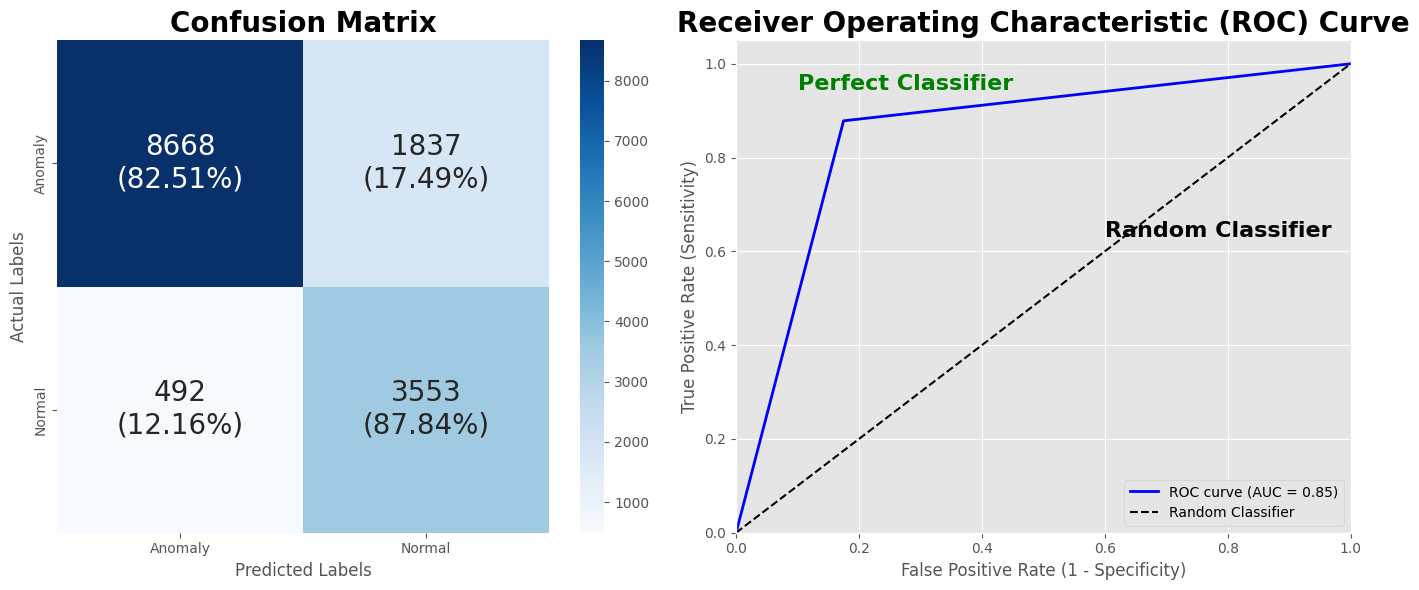

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

def plot_confusion_matrix_and_roc_curve(model, train, test, anomaly, threshold=0.5):
    # Prepare the labels and predictions
    ytrue, ypred = prepare_labels(model, train, test, anomaly, threshold=threshold)
    
    # Calculate accuracy, precision, recall, and f1 score
    accuracy = accuracy_score(ytrue, ypred)
    precision = precision_score(ytrue, ypred)
    recall = recall_score(ytrue, ypred)
    f1 = f1_score(ytrue, ypred)
    
    # Confusion matrix
    cm = confusion_matrix(ytrue, ypred)
    cm_norm = confusion_matrix(ytrue, ypred, normalize="true")
    data = np.array([f"{count}\n({pct:.2%})" for count, pct in zip(cm.ravel(), cm_norm.ravel())]).reshape(cm.shape)
    labels = ["Anomaly", "Normal"]
    
    # Plot confusion matrix
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(cm, annot=data, fmt="", xticklabels=labels, yticklabels=labels, cmap='Blues', ax=ax[0], annot_kws={"size": 20})
    ax[0].set_ylabel("Actual Labels")
    ax[0].set_xlabel("Predicted Labels")
    ax[0].set_title("Confusion Matrix", weight="bold", size=20)
    
    fpr, tpr, thresholds = roc_curve(ytrue, ypred)
    
    auc = roc_auc_score(ytrue, ypred)
    
    # Plot ROC curve
    ax[1].plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='blue', linewidth=2)
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('False Positive Rate (1 - Specificity)')
    ax[1].set_ylabel('True Positive Rate (Sensitivity)')
    ax[1].set_title('Receiver Operating Characteristic (ROC) Curve', weight="bold", size=20)
    ax[1].legend(loc="lower right")
    
    ax[1].annotate('Perfect Classifier', xy=(0, 1), xytext=(0.1, 0.9), textcoords='axes fraction',
                   fontsize=16, color='green', weight='bold')
    ax[1].annotate('Random Classifier', xy=(0.5, 0.5), xytext=(0.6, 0.6), textcoords='axes fraction',
                   fontsize=16, color='black', weight='bold')

    plt.tight_layout()
    fig.savefig("Results.png")
    plt.show()

    
plot_confusion_matrix_and_roc_curve(model, X_train, X_test, anomaly, threshold=threshold)

## Model Evaluation Metrics

The following evaluation metrics provide a comprehensive assessment of the performance of our model:

- **Accuracy (76.93%)**: Accuracy measures the proportion of correct predictions out of all predictions made by the model, indicating an exceptionally high overall classification correctness.

- **Precision (55.23%)**: Precision is the percentage of true positive predictions relative to all positive predictions made by the model, signifying the model's precision in correctly identifying positive instances.

- **Recall (89.81%)**: Recall, also known as sensitivity, represents the model's ability to accurately identify positive instances out of all actual positive instances, demonstrating a strong capability to capture true positives.

- **F1 Score (65.40%)**: The F1 score is a composite metric that balances precision and recall, providing an overall measure of model performance. 

In [27]:
ytrue, ypred = prepare_labels(model, X_train, X_test, anomaly, threshold=threshold)
print(classification_report(ytrue, ypred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Normal       0.95      0.83      0.88     10505
     Anomaly       0.66      0.88      0.75      4045

    accuracy                           0.84     14550
   macro avg       0.80      0.85      0.82     14550
weighted avg       0.87      0.84      0.85     14550



Thank you for taking the time to explore my notebook and delve into the world of data science with me. Your interest and engagement are greatly appreciated, and I hope you found valuable insights and inspiration within these pages.